# LSTM Autoencoder

LSTM Autoencoder는 sequence data에 Encoder-Decoder LSTM 아키텍처를 적용하여 구현. Input sequence가 순차적으로 들어오게 되고, 마지막 input sequence가 들어온 후 decoder는 input sequence를 재생성하거나 혹은 target sequence에 대한 예측을 출력

# Reconstruction LSTM Autoencoder

재구성(reconstruction)을 위한 Autoencoder. Input과 최대하게 유사한 output을 decoding, LSTM 학습을 위해 데이터를 (sample, timesteps, feature)와 같은 3D형태로 변환.

## Imports

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
sequence = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [4]:
num_in = len(sequence)

In [5]:
sequence = sequence.reshape((1, num_in, 1))

## Model

In [6]:
inputs = Input(shape = (num_in, 1))
x = LSTM(100, activation = 'relu')(inputs)
x = RepeatVector(num_in)(x)
x = LSTM(100, activation = 'relu', return_sequences=True)(x)
x = TimeDistributed(Dense(1))(x)

model = Model(inputs, x)

In [8]:
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 9, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 100)            80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


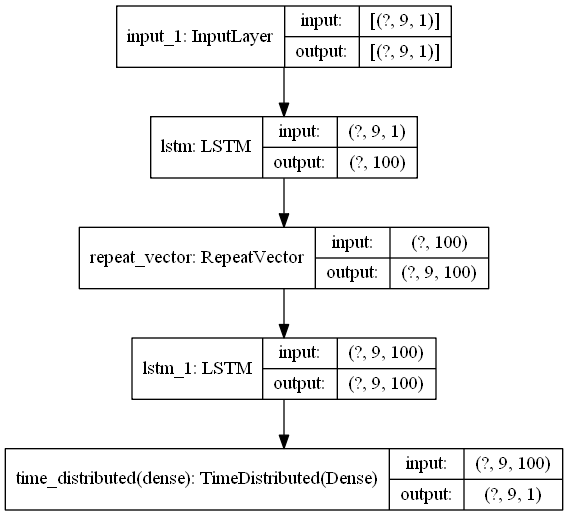

In [14]:
plot_model(model, show_shapes=True)

In [9]:
model.fit(sequence, sequence, epochs=300, verbose=0)

In [10]:
y_hat = model.predict(sequence)

In [11]:
y_hat

array([[[0.11278394],
        [0.20763865],
        [0.30311114],
        [0.39934528],
        [0.49661282],
        [0.59529835],
        [0.6958655 ],
        [0.7989111 ],
        [0.9051898 ]]], dtype=float32)

# Prediction LSTM Autoencoder

LSTM for time series prediction. Input sequence는 t시점, output은 t+1시점

In [20]:
seq_in = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [21]:
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
seq_in.shape

(1, 9, 1)

In [47]:
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1
seq_out

array([[[0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]])

## Model

In [48]:
inputs = Input(shape = (n_in, 1))
x = LSTM(100, activation = 'relu')(inputs)
x = RepeatVector(n_out)(x)
x = LSTM(100, activation = 'relu', return_sequences=True)(x)
x = TimeDistributed(Dense(1))(x)
model_p = Model(inputs, x)

In [49]:
model_p.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9, 1)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 8, 100)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 100)            80400     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 8, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


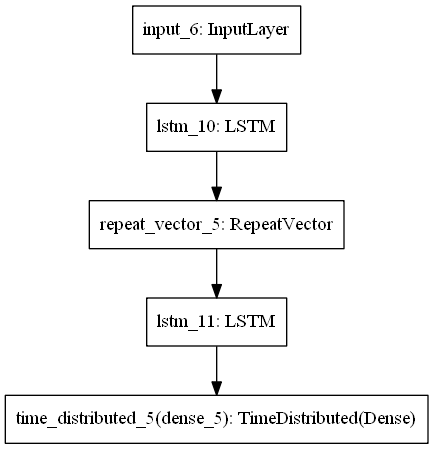

In [50]:
plot_model(model_p)

In [53]:
model_p.compile(optimizer='adam', loss='mse')

In [54]:
model_p.fit(seq_in, seq_out, epochs=300, verbose=0)

In [56]:
yhat = model_p.predict(seq_in)
print(seq_in)
print(yhat)

[[[0.1]
  [0.2]
  [0.3]
  [0.4]
  [0.5]
  [0.6]
  [0.7]
  [0.8]
  [0.9]]]
[[[0.19804798]
  [0.30169964]
  [0.4004311 ]
  [0.500046  ]
  [0.599759  ]
  [0.69970095]
  [0.7995326 ]
  [0.9004605 ]]]


# Composite LSTM Autoencoder

Reconstruction + Prediction

In [57]:
seq_in = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
seq_in.shape
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1

## Model

In [61]:
inputs = Input(shape=(n_in, 1))
encoder = LSTM(100, activation='relu')(inputs)

#Reconstruction
decoder_1 = RepeatVector(n_in)(encoder)
decoder_1 = LSTM(100, activation='relu', return_sequences=True)(decoder_1)
decoder_1 = TimeDistributed(Dense(1))(decoder_1)

#Prediction
decoder_2 = RepeatVector(n_out)(encoder)
decoder_2 = LSTM(100, activation='relu', return_sequences=True)(decoder_2)
decoder_2 = TimeDistributed(Dense(1))(decoder_2)

model = Model(inputs = inputs, outputs = [decoder_1, decoder_2])

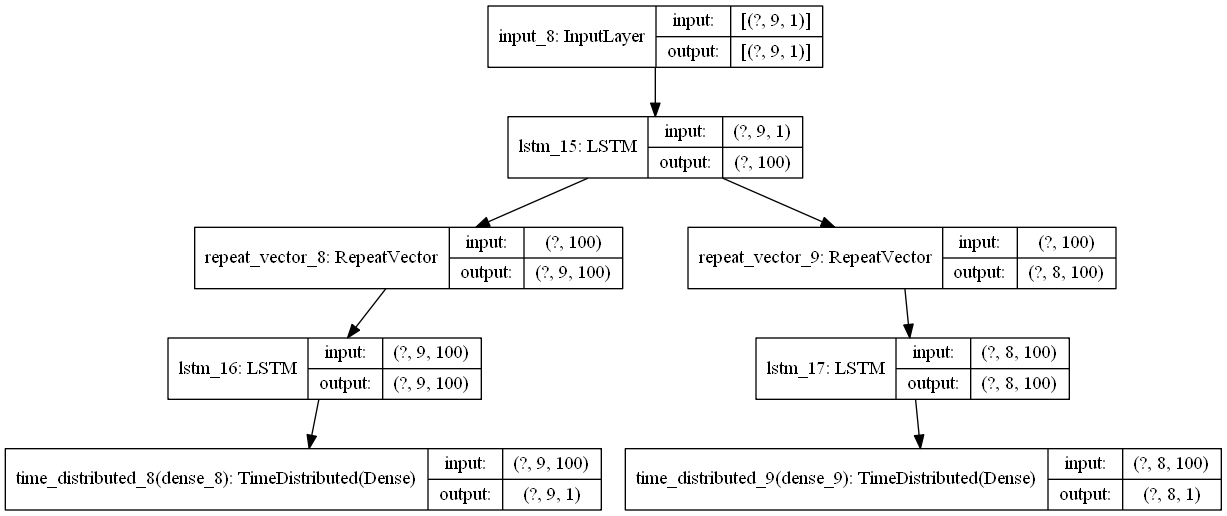

In [63]:
plot_model(model, show_shapes=True)

In [64]:
model.compile(optimizer='adam', loss='mse')

In [65]:
model.fit(seq_in, [seq_in, seq_out], epochs=300, verbose=0)

In [66]:
yhat = model.predict(seq_in)
yhat

[array([[[0.10890768],
         [0.20495972],
         [0.30269274],
         [0.40112865],
         [0.49992988],
         [0.59921926],
         [0.69944113],
         [0.8012779 ],
         [0.90560365]]], dtype=float32),
 array([[[0.17004782],
         [0.29460818],
         [0.40544817],
         [0.5071529 ],
         [0.6036724 ],
         [0.69881785],
         [0.7965795 ],
         [0.90152895]]], dtype=float32)]